In this homework, you need to solve four tasks. The assignment should be uploaded in Jupyter Notebook format(`.ipynb`). Overall, there are 23 points, however, you can get a maximum of 20 points for this assignment( `your_points = max(your_points, 20)`). No bonus points will be transferred to the next assignment.

# Task 1. Non-parametric Density Estimation (6 points)

In [1]:
import numpy as np
import numpy.linalg as nla
import scipy
import scipy.stats as sps
import pandas as pd

from statsmodels.nonparametric.kernel_regression import KernelReg
from sklearn.model_selection import GridSearchCV, cross_validate, LeaveOneOut
from sklearn.neighbors import KernelDensity, NearestNeighbors
from sklearn.metrics.pairwise import rbf_kernel


import warnings
warnings.filterwarnings("ignore")

In [2]:
# Matplotlib settings
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


# non-interactive
%matplotlib inline

#jupyterlab
# %matplotlib widget 

#jupyter-notebook
#%matplotlib notebook 

titlesize = 20
labelsize = 16
legendsize = labelsize
xticksize = 14
yticksize = xticksize

matplotlib.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
matplotlib.rcParams['legend.handletextpad'] = 0.5
matplotlib.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
matplotlib.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['axes.labelsize'] = labelsize
matplotlib.rcParams['axes.titlesize'] = titlesize

matplotlib.rc('xtick', labelsize=xticksize)
matplotlib.rc('ytick', labelsize=yticksize)
matplotlib.rc('legend', fontsize=legendsize)

matplotlib.rc('font', **{'family':'serif'})

You will work with data sampled from the mixture of Normal distributions:

In [3]:
seed1 = 31337
seed2 = 42
n_samples = 100

f1 = scipy.stats.norm(loc=0, scale=1)
f2 = scipy.stats.norm(loc=5, scale=1)
p1 = 0.3
p2 = 1 - p1

Xa = f1.rvs(size=int(p1 * n_samples), random_state=seed1)
Xb = f2.rvs(size=int(p2 * n_samples), random_state=seed2)
samples = np.concatenate([Xa, Xb])

a = -5
b = 10

x_values = np.linspace(a, b, 1000)
binedges = np.linspace(a, b, 10)
true_pdf = p1 * f1.pdf(x_values) + p2 * f2.pdf(x_values)

In [4]:
print(np.mean(Xa))
print(np.mean(Xb))
print(np.var(Xa))
print(np.var(Xb))
print(np.min(samples))
print(np.max(samples))

0.03689581576379748
4.865287844298487
0.9935411999787792
0.7977395621619012
-2.4302277402345944
6.852278184508938


## Histogram estimate

$\newcommand{\boldX}{\boldsymbol{X}}$
$\newcommand{\xs}[1]{\boldX^{(#1)}}$
$\newcommand{\Sum}{\sum\limits}$
$\newcommand{\Int}{\int\limits}$
$\newcommand{\hatp}{\widehat{p}}$
$\newcommand{\hatJ}{\widehat{J}}$
$\newcommand{\lp}{\left(}$
$\newcommand{\rp}{\right)}$

Given a sample $\boldsymbol{X}^{(n)} = \boldsymbol{X}_1, \boldsymbol{X}_2, ..., \boldsymbol{X}_n \sim \; iid \; p(x)$ we would like to build a hitogram estimate of the density. If we have $m$ bins of size $h$, we can have the following estimates of risk using leave-one-out cross validation:

\begin{gather*}
J(h) = \int \hatp^2\lp x;\xs{n} \rp dx - 2 \int \hatp \lp x;\xs{n} \rp p(x) dx, 
\end{gather*}
\begin{gather*}
\hatJ(h) = \int \hatp^2 \lp x;\xs{n} \rp dx - \frac{2}{n}\Sum_{i = 1}^n \hatp \lp \boldsymbol{X}_i ;\xs{n\backslash i} \rp, \label{eq1}\tag{1}
\end{gather*}
\begin{gather*}
\hatJ(h) = \frac{2}{(n - 1)h} - \frac{n+1}{(n-1)h}\Sum_{i = 1}^m \hatp_j^2,\quad \hatp_j = \frac{n_j}{n}. \label{eq2}\tag{2}
\end{gather*}

Your task is:
1. Build a histogram estimate of the pdf given the sample above, tune bandwidth using leave-one-out CV. Use formula (\ref{eq2}). Also check out `np.histogram` (1 point)

In [5]:
def bins_count(X, h):
    return np.int(np.ceil((np.max(X) - np.min(X)) / h))

def get_bandwidth(X, bins_num):
    return (np.max(X) - np.min(X)) / bins_num
    
def J_estimate(h, X):
    n = len(X)
    X_min, X_max = np.min(X), np.max(X)
    bins_num = bins_count(X, h)
    p =  np.histogram(X, bins = bins_num, range = (np.min(X), np.max(X)), density = False)[0]
    summ = np.sum([(n_i / n)**2 for n_i in p])
    return 2 / ((n-1) * h) - (n + 1) / ((n-1) * h) * summ

In [6]:
h_list = np.logspace(-2, 1, 1500)
cv_list = [J_estimate(h_i, samples) for h_i in h_list]
j_min = np.argmin(cv_list)
h_opt = h_list[j_min]
J_est_min = cv_list[j_min]

bins_opt = bins_count(samples, h_opt)
bw_opt = get_bandwidth(samples, bins_opt)
    
print(h_opt, J_est_min, bins_opt)

0.8458334509090585 -0.16162171212089912 11


2.\* Prove that for histograms (2) follows from (1) (1 bonus point)


##### We have to prove that 
$$
\hatJ(h) = \frac{2}{(n - 1)h} - \frac{n+1}{(n-1)h}\Sum_{i = 1}^m \hatp_j^2,\quad \hatp_j = \frac{n_j}{n}
$$
##### follows from
$$
\begin{gather*}
\hatJ(h) = \int \hatp^2 \lp x;\xs{n} \rp dx - \frac{2}{n}\Sum_{i = 1}^n \hatp \lp \boldsymbol{X}_i ;\xs{n\backslash i} \rp
\end{gather*}
$$
##### Consider first part of this expression:
$$
I_1 = \int \hat p^2(x; X^{n}) dx = \int \dfrac{1}{n^2 h^2} (\sum \limits_{i = 1}^{n} \mu_i \mathbb{1}(x \in \Delta_i))^2 = \int \dfrac{1}{n^2 h^2} \sum \limits_{i = 1}^{n} \mu_i^2 \mathbb{1}(x \in \Delta_i) = \dfrac{1}{n^2 h^2} \sum \limits_{i = 0}^{n} \mu_i^2 h,
$$
##### where $h$ is the size of intervals $\Delta_i$ and $\mu_i$ is the number of samples falling into  $\Delta_i$. If $\hat p_i = \dfrac{\mu_i}{n}$ - fraction of samples falling into  $\Delta_i$, then
$$
I_1 = \dfrac{1}{h} \sum \limits_{i = 1}^{n} \hat p_i^2,
$$
##### Consider second part of this expression:
$$
I_2 = \frac{1}{n}\Sum_{i = 1}^n \hatp (X_i; X^{n\backslash i}) = \frac{1}{n} \dfrac{\sum\limits_{i=1}^{n} (\mu_i^2 - 1)}{(n-1)h} = \frac{1}{n} \dfrac{\sum\limits_{i=1}^{n}\mu_i^2 - n}{(n-1)h} = \dfrac{n \sum\limits_{i=1}^{n} \hat p_i^2 - 1}{(n-1)h}
$$
##### Here we have square of $\mu_i$ because in this expression we sum over all samples (not bins), so each $\mu_i$ appears  $\mu_i$ times.
##### Therefore,
$$
\hat J(h) = I_1 - 2 I_2 = \dfrac{1}{h} \sum \limits_{i = 0}^{n} \hat p_i^2 - 2 \dfrac{n \sum\limits_{i=1}^{n} \hat p_i^2 - 1}{(n-1)h} = \dfrac{2}{(n-1)h} - \dfrac{n+1}{(n-1)h} \sum\limits_{i=1}^{n} \hat p_i^2
$$

3. Plot CV estimates $\hatJ(h)$ that you obtained during selection. Mark optimal bandwidth $h_{cv}$ and report $h_{cv}$ and $\hatJ(h_{cv})$ (0.5 point)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


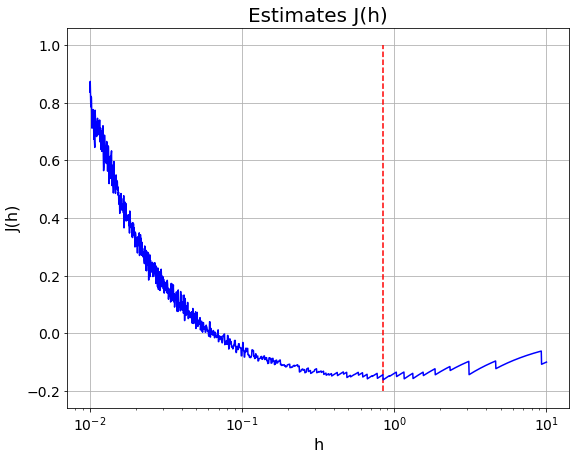

In [7]:
plt.figure(figsize=(9,7))
plt.plot(h_list, cv_list, color = 'b')
plt.vlines(h_opt, -0.2, 1, colors='r', linestyles = 'dashed', label='h_opt')
plt.xlabel('h')
plt.ylabel('J(h)')
plt.grid(True)
plt.title('Estimates J(h)')
plt.xscale("log")
plt.show()

In [8]:
print("Optimal bandwidth " + str(round(h_opt, 5)) + " with risk " + 
      str(round(J_est_min, 5)) + " and optimal bins count = " + str(bins_opt))

Optimal bandwidth 0.84583 with risk -0.16162 and optimal bins count = 11


4. Recall the approximation to $MISE$ from Lecture 7, slides 11-13. Assume an Oracle calculated the integral of the squared derivative of the true density for you and the value is $0.0804924$. What will be the approximate optimal bandwidth $h^*$? Find CV estimate of $J$ for this value of bandwidth and compare it to the one found in part 1 (0.5 point)

In [9]:
p_sq_int = 0.0804924
h_star = ((6 / p_sq_int) ** (1/3)) / (n_samples ** (1/3))
J_star = J_estimate(h_star, samples)
bins_star = bins_count(samples, h_star)
print("Minimal MISE in h = " + str(round(h_star, 5)) + " with risk estimate " + 
      str(round(J_star, 5)) + " and bins num " + str(bins_star))

Minimal MISE in h = 0.9067 with risk estimate -0.15077 and bins num 11


###### This value is a bit larger (and with the larger estimate $J(h)$) but quite close to the one we found in the part 1. Bins number remains the same. 

5. `np.histogram` has some built-in methods of selecting bandwidth. Compare some of them with your result and theoretical approximation (again, using CV estimate of $J$) (1 point)

In [10]:
method = ['auto', 'fd', 'scott', 'rice', 'sturges', 'sqrt']

for i in range(6):
    hist, bin_edges = np.histogram(samples, bins = method[i], range = (np.min(samples), np.max(samples)), density = False)
    bw_np = get_bandwidth(samples, len(bin_edges))
    J_np = J_estimate(bw_np, samples)
    print('For method ' + str(method[i]) + ' h = ' + str(len(bin_edges)) + 
          ', bandwidth: ' + str(round(bw_np, 5)) + ' and risk estimate ' + str(round(J_np, 5)))

For method auto h = 9, bandwidth: 1.03139 and risk estimate -0.15094
For method fd h = 6, bandwidth: 1.54708 and risk estimate -0.14745
For method scott h = 7, bandwidth: 1.32607 and risk estimate -0.15741
For method rice h = 11, bandwidth: 0.84386 and risk estimate -0.162
For method sturges h = 9, bandwidth: 1.03139 and risk estimate -0.15094
For method sqrt h = 11, bandwidth: 0.84386 and risk estimate -0.162


###### We can observe that methods 'rice' and 'sqrt' give us the lowest J estimate.
##### If we just use $ np.histogram\_bin\_edges$ without any method of bins counting:

In [11]:
p = np.histogram_bin_edges(samples)
bins_np = p.shape[0]
bw_np = get_bandwidth(samples, bins_opt)
J_np = J_estimate(bw_np, samples)
print('Bins num: ' + str(bins_np) + ', bandwidth for it ' + str(round(bw_np, 5)) +
                                                            ' and J estimate ' + str(round(J_np, 5)))

Bins num: 11, bandwidth for it 0.84386 and J estimate -0.162


--------------------------------

## Kernel density estimate

In this part, you will use the same sample, but employ the kernel density estimation method. We can use the same proxy expression to optimise the risk:
\begin{gather*}
J(h) = \int \hatp^2 \lp x;\xs{n} \rp dx - 2 \int \hatp \lp x;\xs{n} \rp p(x) dx
\end{gather*}

In out case of kernel estimator, we can obtain:
\begin{gather*}
\hatJ(h) = \frac{1}{hn^2}\Sum_{i = 1}^n\Sum_{j = 1}^n K^{(2)}\lp\frac{x_i - x_j}{h}\rp + \frac{2 K(0)}{nh}, \label{eq3}\tag{3}
\end{gather*}
where
\begin{gather*}
K^{(2)}(x) = K^*(x) - 2K(x), \quad K^*(x) = \int K(x - y) K(y) dy.
\end{gather*}

You can use [kernel density estimation from sklearn](http://scikit-learn.org/stable/modules/density.html). Your task is:
1. Build a kernel density estimate given the sample from before, tune bandwidth using leave-one-out CV. Try two different kernels of your choice. Use formula \ref{eq3} for your estimates (1 point)

In [12]:
sample_min, sample_max = np.min(samples), np.max(samples)
delta = sample_max - sample_min
grid = np.linspace(sample_min, sample_max, 100)

##### For risk estimate I took three kernels: gaussian, rectangular and Epanechnikov. I computed their convolutions using Wolfram Alpha (functions kernel_i_conv):

In [13]:
#kernel = lambda x, y, h: rbf_kernel(x, y, 0.5 / h**2) / (2 * np.pi)**(x.shape[1] / 2)
kernel_1 = lambda x: np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)
kernel_2 = lambda x: 1/2 * (np.abs(x) < 1)
kernel_3 = lambda x: 3/4 * (1 - x**2) * (np.abs(x) < 1)

def kernel_1_conv(x):
    return np.exp(-x**2 / 4) / (2 * np.sqrt(np.pi)) - 2 * kernel_1(x)

def kernel_3_conv(x):
    res = 9 / (30 * 16)
    if (x > 0 and x < 2):
        res *=  -(x - 2)**3 * (x**2 + 6*x + 4)
        return res - 2 * kernel_3(x)
    elif (x > -2 and x <= 0):
        res *= (x + 2)**3 * (x**2 - 6*x + 4)
        return res - 2 * kernel_3(x)
    else:
        return (- 2) * kernel_3(x)
    
def kernel_2_conv(x):
    if (x > 0 and x < 2):
        return 1/4 * (2 - x) - 2 * kernel_2(x)
    elif (x > -2 and x <= 0.):
        return 1/4 * (x + 2) - 2 * kernel_2(x)
    else:
        return (-2) * kernel_2(x)
    
def J_kernel_estimate(kernel, kernel_conv, X, h):
    n = len(X)
    sample_min, sample_max = np.min(X), np.max(X)
    bins = bins_count(X, h)
    mask = np.ones(n, dtype=np.bool_)
    X = X[:, None]
    res = 2 * kernel(0) / (n * h)
    for i in range(len(X)):
        for j in range(len(X)):
            res += kernel_conv((X[i] - X[j]) / h) / (h * n**2)
    return res

    #for i in range(n):
    #    mask[i] = False
    #    p = KernelDensity(bandwidth=h).fit(sample[mask])
    #    mask[i] = True
    #    summ += np.exp(p.score_samples(sample[i].reshape(1, 1)))
    #summ = 2 * summ / n * h
    #p = KernelDensity(bandwidth=h).fit(sample[mask]).score_samples(np.linspace(sample_min, sample_max, 101)[:, None])
    #p /= p.sum()
    #summ += np.sum(p**2) / h

##### Grid search with leave-one-out cross-validations with two kernels: gaussian and Epanechnikov

In [14]:
params = {'bandwidth': np.logspace(-1, 2, 200)}
kernels = ['gaussian', 'epanechnikov']
kde = []
for kernel in kernels:
    grid_search = GridSearchCV(KernelDensity(kernel = kernel), params, cv=LeaveOneOut())
    grid_search.fit(samples.reshape(-1, 1))
    kde.append(grid_search.best_estimator_)
    #p1 = np.exp(kde.score_samples(samples.reshape(-1, 1)))
    if (kernel =='gaussian'):
        print('For gaussian kernel:')
    else:
        print('For Epanechnikov kernel:')
    print('Bandwidth =', kde[-1].bandwidth)
    if (kernel == 'gaussian'):
        print('J estimate for this bandwidth:', J_kernel_estimate(kernel_1, kernel_1_conv, samples, kde[-1].bandwidth)[0])
    else:
        print('J estimate for this bandwidth:', J_kernel_estimate(kernel_3, kernel_3_conv, samples, kde[-1].bandwidth)[0])
    print('---------------------------------------------')

For gaussian kernel:
Bandwidth = 0.49370478528390027
J estimate for this bandwidth: -0.1607864944650761
---------------------------------------------
For Epanechnikov kernel:
Bandwidth = 1.135733358343105
J estimate for this bandwidth: -0.1618706846455322
---------------------------------------------


2. Plot CV estimates $\hatJ(h)$ that you obtained during selection. Mark optimal bandwidth $h_{cv}$ and report $h_{cv}$ and $\hatJ(h_{cv})$. What kernel worked better in terms of estimated risk? (0.5 point)

In [ ]:
h_list = np.logspace(-3, 1, 100)
cv_list = [J_kernel_estimate(kernel_1, kernel_1_conv, samples, h_i) for h_i in h_list]
j_min = np.argmin(cv_list)
h_opt = h_list[j_min]
J_est_min = cv_list[j_min][0]

print('For gaussian:')
print('h = ' + str(round(h_opt, 5)) + ', risk estimate ' + 
                   str(round(J_est_min, 5)))

In [ ]:
h_list_2 = np.logspace(-3, 1.5, 150)
cv_list_2 = [J_kernel_estimate(kernel_2, kernel_2_conv, samples, h_i) for h_i in h_list_2]
j_min_2 = np.argmin(cv_list_2)
h_opt_2 = h_list_2[j_min_2]
J_est_min_2 = cv_list_2[j_min_2][0]

print('For rectangular:')
print('h = ' + str(round(h_opt_2, 5)) + ', risk estimate ' + 
                   str(round(J_est_min_2, 5)))

In [ ]:
h_list_3 = np.logspace(-3, 1.5, 150)
cv_list_3 = [J_kernel_estimate(kernel_3, kernel_3_conv, samples, h_i) for h_i in h_list_3]
j_min_3 = np.argmin(cv_list_3)
h_opt_3 = h_list_3[j_min_3]
J_est_min_3 = cv_list_3[j_min_3][0]

print('For Epanechnikov:')
print('h = ' + str(round(h_opt_3, 5)) + ', risk estimate ' + 
                   str(round(J_est_min_3, 5)))

In [ ]:
plt.figure(figsize=(9,7))
plt.plot(h_list, cv_list, color = 'b')
plt.vlines(h_opt, -0.2, 2.5, colors='r', linestyles = 'dashed', label='h_opt')
plt.xlabel('h')
plt.ylabel('J(h)')
plt.grid(True)
plt.title('Estimates J(h) with gaussian kernel')
plt.xscale("log")
plt.show()

In [ ]:
plt.figure(figsize=(9,7))
plt.plot(h_list_2, cv_list_2, color = 'b')
plt.vlines(h_opt_2, -0.2, 5, colors='r', linestyles = 'dashed', label='h_opt')
plt.xlabel('h')
plt.ylabel('J(h)')
plt.grid(True)
plt.title('Estimates J(h) with rectangular kernel')
plt.xscale("log")
plt.show()

In [ ]:
plt.figure(figsize=(9,7))
plt.plot(h_list_3, cv_list_3, color = 'b')
plt.vlines(h_opt_3, -0.2, 6, colors='r', linestyles = 'dashed', label='h_opt')
plt.xlabel('h')
plt.ylabel('J(h)')
plt.grid(True)
plt.title('Estimates J(h) with Epanechnikov kernel')
plt.xscale("log")
plt.show()

##### In terms of risk approximated rectangular kernel worked best, which is surprising because it has the simpliest form.

In [ ]:
#h_ar = np.logspace(-1, 1.3, 100)
h_ar = np.linspace(-2.5, 7.5, 500)
h_ar = np.array(h_ar)

plt.figure(figsize=(12, 6))
plt.hist(samples, bins=11, density=True);
for kernel, kde_ in zip(kernels, kde):
    density = KernelDensity(kernel=kernel, bandwidth=kde_.bandwidth).fit(samples.reshape(-1, 1))
    plt.plot(h_ar, np.exp(density.score_samples(h_ar[:, None])), label=kernel, linewidth=4)
plt.legend()
plt.title('Kernel density estimate')
plt.show()

3. Recall the approximation to $MISE$ from Lecture 7, slide 20. Assume an Oracle calculated the integral of the squared second derivative of the true density for you and the value is $0.127529$. What will be the approximate optimal bandwidth $h^*$? Find CV estimate of $J$ for this value of bandwidth and compare it to the one found in part 1 (0.5 point)

gaussian kernel: 

$$
K(x) = \dfrac{\exp^{-x^2}}{\sqrt{2\pi}} 
$$
Find an integral from $-\infty$ to $\infty$ of its square:
$$
\int K^2(x) dx = \dfrac{1}{2 \sqrt{\pi}} = 0.282095
$$
And an integral $\int x^2 K(x)dx$:
$$
\int x^2 K(x) dx = 1
$$

In [ ]:
p_2_int = 0.127529
k_2_int = 0.282095
h_star = (1 / n_samples * k_2_int / p_2_int) ** (1/5)
print('h*:', h_star)
print('Risk estimated:', J_kernel_estimate(kernel_1, kernel_1_conv, samples, h_star)[0])

##### Same for Epanechnikov kernel (integrals are counted through Wolfram Alpha)

In [ ]:
h_star_epn = (1 / ((1/5)**2 * n_samples) * 3/5 / p_2_int) ** (1/5)
print('h*:', h_star_epn)
print('Risk estimated:', J_kernel_estimate(kernel_3, kernel_3_conv, samples, h_star_epn)[0])

---------------------------------------------

# Task 2. Non-parametric Regression (5.5 pt)

In this task you will apply non-parametric regression to airport statistics data.

### Data loading and preprocessing

Load dataset from `airport_operations_report.csv`. Use `General Aviation: Total Operations` as target(dependent) variable and `[Air Carrier Operations, General Aviation: Local Operations]` as covariates(independent variables). Divide $1^{st}$ covariate by `1000`, $2^{nd}$ by `100` and target by `1000`. Make 2D grid for covariates from minimum to maximum values with `100` steps along each dimension.

In [ ]:
# Your code
df = pd.read_csv('airport_operations_report.csv')
print(df.columns)
print(df.shape)
X = np.array([df['Air Carrier Operations'].values, df['General Aviation: Local Operations'].values]).T
print(X.shape)
X[:, 0] /= 1000
X[:, 1] /= 100
#X['Air Carrier Operations'][:] /= 1000
#X['General Aviation: Local Operations'][:] /= 100
y = np.array(df['General Aviation: Total Operations'].values)
print(y.shape)
y[:] /= 1000

In [ ]:
cov_1 = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
cov_2 = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
xx, yy = np.meshgrid(cov_1, cov_2)

grid = np.stack([xx, yy])
grid = np.transpose(grid, (1, 2, 0))
grid = grid.reshape(-1, 2)
print(grid.shape)

### Fit model (1 pt)

Perform a nonparametric regression to fit the model $Y = f(x)+\varepsilon$. 

In [ ]:
model = KernelReg(endog = y, exog = X, var_type='cc', reg_type='lc')

Predict values for created grid.

In [ ]:
# step_numbers - number of steps in grid: (100, 100)
step_numbers = (100, 100)

target_pred, margins = model.fit(grid)
target_pred = target_pred.reshape(*step_numbers)
grid = grid.reshape(*step_numbers, 2)

This is function to visualize 3D surfaces. You can modify it if you need.

In [ ]:
def plot_surface_function(x1, x2, y, minmax_values=None, ax=None):
    if ax is None:
        fig = plt.figure(figsize = (8, 8))
        ax = fig.gca(projection='3d')

        surf = ax.plot_surface(x1, x2, y, cmap=cm.rainbow, linewidth=0.5, alpha=0.5, edgecolor="k")
        if minmax_values is not None:
            ax.set_xlim3d(*minmax_values[0])
            ax.set_ylim3d(*minmax_values[1])
    else:
        surf = ax.plot_surface(x1, x2, y, cmap=cm.bwr, linewidth=0.5, alpha=0.3, edgecolor="k")
    return ax

Let's plot estimated surface.

In [ ]:
# target - dependent variable
# grid - grid for covariates
# sample - covariates

sample_min = [np.min(grid[:, :, 0]), np.min(grid[:, :, 1])]
sample_max = [np.max(grid[:, :, 0]), np.max(grid[:, :, 1])]

ax = plot_surface_function(grid[:, :, 0], grid[:, :, 1], target_pred, minmax_values=np.vstack((sample_min, sample_max)).T)
ax.scatter(X[:, 0], X[:, 1], y, marker="o", s=25, c="r")

In [ ]:
print('Optimal bandwidth by KernelReg:', model.bw)

### Estimate confidence intervals (2 pt)

Construct 95\% confidence bands for your estimate. To estimate error variance for 1D covariate, you sort your sample and subtract target values in the nearest points. For 2D covariate, you should, for each point, calculate the difference in target values between a point and its nearest neighbor(in euclidian metric). To get power for quantile of standard normal distribution, which is $\frac{w}{b-a}$ for 1D, estimate it per coordinate and multiply: $\prod_{i=1}^2 \frac{w_i}{b_i-a_i}$. 

In [ ]:
def kernel_2d(x, y, h):
    return rbf_kernel(x / h, y / h, 0.5) / (2 * np.pi)**(x.shape[1] / 2)

In [ ]:
def prediction_se(grid, sample, target, h, alpha=0.05):
    n = target.shape[0]
    sigma_hat2 = 0
    mask = np.ones(n, dtype=np.bool_)
    for i in range(n):
        mask[i] = False
        neigh = NearestNeighbors(n_neighbors = 1)
        neigh.fit(sample[mask])
        ind = neigh.kneighbors([sample[i]])[1][0][0]
        if (ind >= i):
            ind += 1
        mask[i] = True
        sigma_hat2 += (target[i] - target[ind])**2
    sigma_hat2 =  sigma_hat2 * (1 / (2 * (n-1)))
    
    delta_1 = np.max(sample[:, 0]) - np.min(sample[:, 0])
    delta_2 = np.max(sample[:, 1]) - np.min(sample[:, 1])

    kernel_values = kernel_2d(grid, sample, h)
    kernel_sum = np.sum(kernel_values, axis=1, keepdims=True)
    kernel_weights = kernel_values / kernel_sum
    
    se = np.sqrt(np.sum(kernel_weights**2, axis=1) * sigma_hat2)
    m = (9 * h[0] * h[1]) / (delta_1 * delta_2)
    q = sps.norm.ppf((1 + (1 - alpha) ** m) / 2)
    return q * se

In [ ]:
grid = grid.reshape(100, 100, 2)
grid_1 = grid.reshape(-1, 2)
qse = prediction_se(grid_1, X, y, model.bw)
qse = qse.reshape(*step_numbers)

Let's plot confidence intervals

In [ ]:
sample_min = [np.min(grid[:, :, 0]), np.min(grid[:, :, 1])]
sample_max = [np.max(grid[:, :, 0]), np.max(grid[:, :, 1])]

ax = plot_surface_function(grid[:, :, 0], grid[:, :, 1], target_pred, minmax_values=np.vstack((sample_min, sample_max)).T)
ax.scatter(X[:, 0], X[:, 1], y, marker="o", s=25, c="r")
ax = plot_surface_function(grid[:, :, 0], grid[:, :, 1], target_pred + qse, ax=ax)
ax = plot_surface_function(grid[:, :, 0], grid[:, :, 1], target_pred - qse, ax=ax)

### Find optimal bandwidth (2 pt)

Use cross-validation to estimate the bandwidth.

In [ ]:
def cross_validation_regression(sample, target, h):
    n = sample.shape[0]
    mask = np.ones(n, dtype=np.bool_)
    bw = h
    summ = 0
    for i in range(n):
        mask[i] = False
        nw = KernelReg(target[mask], sample[mask], var_type="cc", reg_type="lc", bw=bw)
        mask[i] = True
        summ += (target[i] - nw.fit(sample[i].reshape(2, 1))[0])**2
    return summ

Make grid with logarithm step to find best bandwidth, from `0.1` to `10` with `21` steps along each dimension. Visualize obrained results with `plot_surface_function`. Print values for optimal bandwidth.

In [ ]:
order = np.argsort(y)
X_copy = np.vstack((X[order, 0], X[order, 1]))
#np.concatenate((X[order, 0], X[order, 1]), axis=1)
X_copy = np.transpose(X_copy)
print(X_copy.shape)

In [ ]:
h_list = np.logspace(-1, 1, 21)
hxx, hyy = np.meshgrid(h_list, h_list)

h_grid = np.stack([hxx, hyy])
h_grid = np.transpose(h_grid, (1, 2, 0))
h_grid = h_grid.reshape(-1, 2)

cv_hist = np.array([cross_validation_regression(X_copy, y[order], h_) for h_ in (h_grid)])

In [ ]:
#h_min = [np.min(h_2d[:, 0]), np.min(h_2d[:, 1])]
#h_max = [np.max(h_2d[:, 0]), np.max(h_2d[:, 1])]

fig1 = plt.figure(figsize=(8, 8))
ax = fig1.gca(projection='3d')
ax.plot_trisurf(h_grid[:len(cv_hist), 0], h_grid[:len(cv_hist), 1], cv_hist.reshape(-1), cmap=plt.cm.Spectral)
fig1.show()
#ax = plot_surface_function(h_2d[:, 0], h_2d[:, 1], cv_hist)

Plot surface with estimated bandwidth.

In [ ]:
h_opt = h_grid[cv_hist.argmin()]
print('Optimal bandwidth for 21 points per dimension:', h_opt)

In [ ]:
model = KernelReg(endog = y, exog = X, var_type='cc', reg_type='lc', bw=h_opt)
step_numbers = (100, 100)

target_pred, margins = model.fit(grid.reshape(-1, 2))
target_pred = target_pred.reshape(*step_numbers)
grid = grid.reshape(*step_numbers, 2)

sample_min = [np.min(grid[:, :, 0]), np.min(grid[:, :, 1])]
sample_max = [np.max(grid[:, :, 0]), np.max(grid[:, :, 1])]

ax = plot_surface_function(grid[:, :, 0], grid[:, :, 1], target_pred, minmax_values=np.vstack((sample_min, sample_max)).T)
ax.scatter(X[:, 0], X[:, 1], y, marker="o", s=25, c="r")

In [ ]:
h_list = np.logspace(-1, 1, 51)
hxx, hyy = np.meshgrid(h_list, h_list)

h_grid = np.stack([hxx, hyy])
h_grid = np.transpose(h_grid, (1, 2, 0))
h_grid = h_grid.reshape(-1, 2)

cv_hist = np.array([cross_validation_regression(X_copy, y[order], h_) for h_ in (h_grid)])

print('Optimal bandwidth for 51 points per dimension:', h_grid[cv_hist.argmin()])
print('Risk for optimal value:', cv_hist.min())

### Conclusion (0.5 pt)

Write your conclusions about conducted experiments.

##### We tried two approaches for this regression problem: KernelReg and custom cross-validation.
##### From the 3d plot it seems that most of the points are located inside the confidence bands (if some of the point are outside it should be fine because it's just 95% confidence interval).
##### The optimal bandwidth found with usage of KernelReg ($[0.5371977, 0.55854071]$) is quite close to the values found by cross-validation method ($[0.50118723, 0.50118723]$) and they become even closer if we take more frequent grid for cross-validation (not 21 points per dimension as required, but 51 points, for example, and get $[0.52480746, 0.57543994]$). 
##### So we can conclude that these methods are close in their result.

# Task 3. Model Selection (5.5 pt)

In this task you will select model(choose set of covariates) using AIC criteria and forward/backward stepwise regression.

### Data loading and preprocessing

Read dataset `pacn_wrcc.csv`. The target variable is `ly Solar Rad.`, others are covariates.

In [ ]:
df = pd.read_csv("pacn_wrcc.csv")
X_aic = np.array(df.drop(columns=['ly Solar Rad.']).values)
y_aic = np.array(df['ly Solar Rad.'].values)
print(X_aic.shape)
print(y_aic.shape)

Scale covariates to range `[0, 1]` and add bias column.

In [ ]:
from sklearn.preprocessing import MinMaxScaler as scaler

sc = scaler()
X_aic = sc.fit_transform(X_aic)
#X_aic = np.interp(X_aic, (np.min(X_aic), np.max(X_aic)), (0, 1))
X_aic = np.transpose(np.vstack([np.transpose(X_aic), np.ones(y_aic.shape[0])]))
print(X_aic.shape)

### AIC and sample variance (2 pt) 

Estimate sample variance of error with full set of covariates. Take into account number of dependent variables.

$$
\hat\sigma^2 = \dfrac{1}{n-k}\sum\limits_{i=1}^{n} \hat\varepsilon_i^2
$$
$$
\hat\varepsilon = \hat\beta X - Y
$$
$$
k = shape(X^T X)[0]
$$

In [ ]:
sigma_2 = 0
nn = (X_aic.T @ X_aic).shape[0]
beta_hat = np.linalg.inv(X_aic.T @ X_aic) @ X_aic.T @ y_aic #0.0001 * np.ones((nn, nn))
eps = X_aic @ beta_hat - y_aic
k = (X_aic.T @ X_aic).shape[0]

for i in range(eps.shape[0]):
    sigma_2 += eps[i]**2
sigma_2 = sigma_2 / (eps.shape[0] - k)
print(sigma_2)

Implement estimate of AIC for given covariates, target and error variance.

In [ ]:
def aic(X, y, sigma2):
    n = X.shape[0]
    #nn = (X.T @ X).shape[0]
    beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y #0.0001 * np.ones((nn, nn))
    l_s = - n * np.log(np.sqrt(sigma2 * 2 * np.pi))
    l_s = l_s - 1 / (2 * sigma2) * (np.linalg.norm(y - X @ beta_hat) ** 2)
    return l_s - X.shape[1]

### Forward stepwise regression (1 pt)

Implement forward stepwise regression. Save the order in which covariates are added to feature set and AIC values for those feature sets.

In [ ]:
#def forward_stepwise_regression(X, y, sigma2, alpha=0.1):
#    features = []
#    aic_list = []
#    is_improvement = True
#    while (is_improvement):
#        size = len(features)
#        for i in range(X.shape[1]):
#            diff = []
#            if (i not in features):
#                diff.append(aic(X[:, features + [i]], y, sigma2) - aic(X[:, features], y, sigma2))
#                if (np.max(diff) > 0):
#                    features.append(np.argmax(diff))
#                    aic_list.append(aic(X[:, features], y, sigma2))
#        if (len(features) == size):
##            is_improvement = False
#    return features, aic_list

In [ ]:
def forward_stepwise_regression(X, y, sigma2):
    features = []
    aic_list = []
    idxes = [i for i in range(X.shape[1])]
    eps = -1e10
    
    while(idxes):
        size = len(idxes)
        aic_cur = []
        for i in idxes:
            features_1 = features + [i]
            aic_cur.append(aic(X[:, features_1], y, sigma2))
        value = np.max(aic_cur)
        if (value > eps):
            eps = value
            aic_list.append(value)
            features = features + [idxes[np.argmax(aic_cur)]]
            idxes.remove(idxes[np.argmax(aic_cur)])
            #print(idxes)
        if (len(idxes) == size):
            break
    return features, aic_list

In [ ]:
features, aic_list = forward_stepwise_regression(X_aic, y_aic, sigma_2)
for a, aic_value in enumerate(aic_list, 1):
    print(f"AIC {aic_value:.3f} + {features[:a]}")

### Backward stepwise regression (1 pt)

Implement backward stepwise regression. Save the order in which covariates are removed from feature set and AIC values for those feature sets.

In [ ]:
def backward_stepwise_regression(X, y, sigma2, alpha=0.1):
    features = []
    aic_list = []
    
    idxes = [i for i in range(X.shape[1])]
    eps = -1e10
    
    while(idxes):
        size = len(idxes)
        aic_cur = []
        for i in idxes:
            features_1 = idxes.copy()
            features_1.remove(i)
            aic_cur.append(aic(X[:, features_1], y, sigma2))
        value = np.max(aic_cur)
        if (value > eps):
            eps = value
            aic_list.append(value)
            features = features + [idxes[np.argmax(aic_cur)]]
            idxes.remove(idxes[np.argmax(aic_cur)])
        if (len(idxes) == size):
            break
    return features, aic_list

In [ ]:
features, aic_list = backward_stepwise_regression(X_aic, y_aic, sigma_2)
for a, aic_value in enumerate(aic_list, 1):
    print(f"AIC {aic_value:.3f} -{features[:a]}")

### Bruteforce (1 pt)

Find best sets of covariates and their AIC for all sizes of feature sets.

In [ ]:
from itertools import combinations
#for i in combinations(range(X_aic.shape[1]), 13):
#    print(list(i))

In [ ]:
def bruteforce(X, y, sigma2, alpha=0.):
    features = []
    aic_list = []
    all_sets = []
    for k in range(1, X.shape[1]):
        for subset in combinations(range(X.shape[1]), k):
            all_sets.append(list(subset))
    eps = -1e10

    for subset in all_sets:
        value = aic(X[:, subset], y, sigma2)
        if (value > eps):
            eps = value
            aic_list.append(value)
            features.append(subset)
    return features, aic_list

In [ ]:
features, aic_list = bruteforce(X_aic, y_aic, sigma_2)
for a, aic_value in enumerate(aic_list):
    print(f"AIC {aic_value:.3f} -{features[a]}")

### Conclusion (0.5 pt)

Write your conclusions about conducted experiments.

##### In my case, the results for all of these 3 methods coincide which is a good sign. I can't say for sure whether they always do because as far as I understand, ideally, for more efficient model selection one should use forward/backward methods together: first, select features with forward method and then delete some of them with backward method. Still, in our case the backward method rejected exactly the same features that weren't chosen in forward, so they are coordinated. The AIC value has improved in almost 3 times.
##### The last thing that should be noticed that the bias column has been thrown out of the model. In our problem it is not necessary for the fitting, although sometimes it is, for example, for fearure vector $x = [1, 2, 3, 4]$ and $y = [3, 5, 7, 9]$.

# Task 4. Local regression (6 points)

In [ ]:
from statsmodels.nonparametric.kernel_regression import KernelReg
from sklearn.linear_model import LogisticRegression

In [ ]:
X = np.array([-3.        , -2.93939394, -2.87878788, -2.81818182, -2.75757576,
       -2.6969697 , -2.63636364, -2.57575758, -2.51515152, -2.45454545,
       -2.39393939, -2.33333333, -2.27272727, -2.21212121, -2.15151515,
       -2.09090909, -2.03030303, -1.96969697, -1.90909091, -1.84848485,
       -1.78787879, -1.72727273, -1.66666667, -1.60606061, -1.54545455,
       -1.48484848, -1.42424242, -1.36363636, -1.3030303 , -1.24242424,
       -1.18181818, -1.12121212, -1.06060606, -1.        , -0.93939394,
       -0.87878788, -0.81818182, -0.75757576, -0.6969697 , -0.63636364,
       -0.57575758, -0.51515152, -0.45454545, -0.39393939, -0.33333333,
       -0.27272727, -0.21212121, -0.15151515, -0.09090909, -0.03030303,
        0.03030303,  0.09090909,  0.15151515,  0.21212121,  0.27272727,
        0.33333333,  0.39393939,  0.45454545,  0.51515152,  0.57575758,
        0.63636364,  0.6969697 ,  0.75757576,  0.81818182,  0.87878788,
        0.93939394,  1.        ,  1.06060606,  1.12121212,  1.18181818,
        1.24242424,  1.3030303 ,  1.36363636,  1.42424242,  1.48484848,
        1.54545455,  1.60606061,  1.66666667,  1.72727273,  1.78787879,
        1.84848485,  1.90909091,  1.96969697,  2.03030303,  2.09090909,
        2.15151515,  2.21212121,  2.27272727,  2.33333333,  2.39393939,
        2.45454545,  2.51515152,  2.57575758,  2.63636364,  2.6969697 ,
        2.75757576,  2.81818182,  2.87878788,  2.93939394,  3.        ])

In [ ]:
Y = np.array([1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

You are given a sample of pairs $(X_i, Y_i)$. The output variable appers to be binary. We know a model for this type of data: logistic regression. In this model we assume the log-odds of the Bernoulli output variable to be a linear function:
$$\mathbb{P}(Y_i = 1 | X_i = x_i) = p(x_i) = \frac{e^{\beta_0 + \beta_1 x_i}}{1 + e^{\beta_0 + \beta_1 x_i}}$$
Lets fit a standard logistic regression to the data:

In [ ]:
logreg = LogisticRegression(penalty='none')
logreg.fit(X.reshape(-1, 1), Y)
p_pred_global = logreg.predict_proba(X.reshape(-1, 1))[:, 1]
print(f"Coefficients of the fitted logistic regression model: b0={logreg.intercept_[0]}, b1={logreg.coef_[0][0]}")

In [ ]:
plt.plot(X, Y, '*', label='Observations')
plt.plot(X, p_pred_global, label='Logictic regression')
plt.legend()

## Local regression

As we can see, the dependence of the outcome on $x$ looks more complex than estimated using logistic regression. We will try to improve it with local regression methods instead.
Instead of a global model, we will approximate conditinal probability of the positive class in a neighbourhood of $x$ with:
$$p(u) \approx \frac{e^{\beta_0 + \beta_1 (u-x) }}{1 + e^{\beta_0 + \beta_1 (u-x)}}, $$
for $u$ close to $x$. The coefficients in this case will depend on $x$. To find them, we will have to fit a (slightly different) model at each new query point $x_{new}$ (point where we want to predict $Y$). We will also need to introduce a notion of 'closenes' of points across $x$ - for this we can use our familiar *kernel functions*. Bringing everything together, we introduce the following local loglikelihood for our proposed model:
$$\ell_x(\beta) = \sum\limits_{i=1}^{n} K\left(\frac{x-X_i}{h}\right)\ell\left(Y_i, \beta_0 + \beta_1 \left(X_i - x\right)\right) = \sum\limits_{i=1}^{n} K\left(\frac{x-X_i}{h}\right) \left(Y_i \left(\beta_0 + \beta_1 \left(X_i - x\right)\right) - \log \left( 1 + e^{\beta_0 + \beta_1 \left(X_i - x\right)} \right) \right),$$
$$\ell(y, z) = yz - \log \left(1 + e^z \right).$$
Here $\ell(y, z)$ is a log-likelohood for a single Bernoulli with log-dds ratio $z = \frac{p}{1-p}$. The local log-likelihood $\ell_x(\beta)$ should be optimized numerically to each new point $x$ to obtain $\widehat{\beta}(x)=(\widehat{\beta_0}(x), \widehat{\beta_1}(x))$. Then, we can predict $Y$ using the logistic model:
$$ \mathbb{P}(Y=1 | X=x) = \frac{e^{\beta_0(x)}}{1 + e^{\beta_0(x)}}.$$
Your task is:
1. Implement the proposed local logistic regression approach using Gaussian kernel. *Hint*: look at additional parameters of the `fit` method of [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) from `sklearn` package (2 points)
2. Select optimal bandwidth using leave-one-out log-likelihood cross-validation: $\ell_{cv} = \sum_i \ell(Y_i, \widehat{z}_{-i}(x_i))$, where $\widehat{z}_{-i}$ is the estimated log-odds ratio without $i$th sample (3 points)
3. Now ignore that the output variable is binary. Compare previous results with local linear kernel regression method using `KernelReg` from `statsmodels`. Use leave-one out squared error cross-validation to select the bandwidth (1 bonus point)

In [ ]:
kernel = lambda x, y, h: rbf_kernel(x, y, 0.5 / h**2) / (2 * np.pi)**(x.shape[1] / 2)

def Local_Logistic_Regression(points, X, Y, h):
    X_kernel = kernel(points.reshape(-1, 1), X.reshape(-1, 1), h)
    proba = np.zeros(points.shape[0])
    for i in range(len(points)):
        regression = LogisticRegression(solver='lbfgs') #penalty='none' 
        regression.fit((X - points[i]).reshape(-1, 1), Y, sample_weight = X_kernel[i])
        beta = regression.intercept_[0]
        proba[i] = np.exp(beta) / (1 + np.exp(beta))
    return proba

In [ ]:
h_1 = 1
h_2 = 1/3
h_3 = 1/6
y_pred_1 = Local_Logistic_Regression(X, X, Y, h_1)
y_pred_2 = Local_Logistic_Regression(X, X, Y, h_2)
y_pred_3 = Local_Logistic_Regression(X, X, Y, h_3)
    
plt.figure(figsize=(9, 9))
plt.plot(X, Y, '*', label='Observations')
plt.plot(X, p_pred_global, label='Logictic regression')
plt.plot(X, y_pred_1, label='Kernel regression with h = 1')
plt.plot(X, y_pred_2, label='Kernel regression with h = 1/3')
plt.plot(X, y_pred_3, label='Kernel regression with h = 1/6')
plt.legend(loc='best')
plt.show()

In [ ]:
def cross_validation_local_regression(sample, target, h):
    n = sample.shape[0]
    mask = np.ones(n, dtype=np.bool_)
    summ = 0
    for i in range(n):
        mask[i] = False
        #probs = Local_Logistic_Regression(np.array([sample[i]]), sample[mask], 
        # target[mask], h)
        probs = Local_Logistic_Regression(np.array([sample[i]]), sample[mask], 
                                          target[mask], h)
        mask[i] = True
        z_i = np.log(probs / (1 - probs))
        summ += (target[i] * z_i - np.log(1 + np.exp(z_i))) 
    return summ

In [ ]:
h_grid = np.logspace(-2, 1, 100) #endpoint=False)
cv_hist = np.array([cross_validation_local_regression(X, Y, h_) for h_ in (h_grid)])

plt.plot(h_grid, cv_hist)

In [ ]:
h_grid = np.logspace(-1, 1, 50) #endpoint=False)
cv_hist = np.array([cross_validation_local_regression(X, Y, h_) for h_ in (h_grid)])

plt.plot(h_grid, cv_hist)

In [ ]:
h_opt_loc = h_grid[np.argmax(cv_hist)]
print('Optimal bandwidth:', h_opt_loc)

##### Now use KernelReg:

In [ ]:
def cross_validation_regression(sample, target, h):
    n = sample.shape[0]
    mask = np.ones(n, dtype=np.bool_)
    bw = [h]
    summ = 0
    for i in range(n):
        mask[i] = False
        nw = KernelReg(target[mask], sample[mask], var_type="o", reg_type="lc", bw=bw)
        mask[i] = True
        summ += (target[i] - nw.fit(sample[i].reshape(-1, 1))[0])**2
    return summ

order = np.argsort(Y)

h_grid = np.logspace(-4, 0, 100, endpoint=False)
cv_hist = np.array([cross_validation_regression(X[order], Y[order], h_) for h_ in (h_grid)])

In [ ]:
plt.plot(h_grid, cv_hist)

In [ ]:
h_grid = np.logspace(-2, 1, 100)
cv_hist = np.array([cross_validation_regression(X[order], Y[order], h_) for h_ in (h_grid)])

plt.plot(h_grid, cv_hist)

In [ ]:
print('Optimal bandwidth:', h_grid[np.argmax(cv_hist)])